In [1]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=14,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=2,        # controls default line thickness
    grid = false,        # turns off grid in background
    fontfamily="Computer Modern" # font family that matches latex
)
using BifurcationKit, DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
using LaTeXStrings
bif_fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :x => 5.0,
    :scale => 5.0
)
using LinearAlgebra, ForwardDiff

# Vary delta (make adjustments to param calculation)

equilibrium_nogroups (generic function with 1 method)

## Plot line of equilibria varying delta

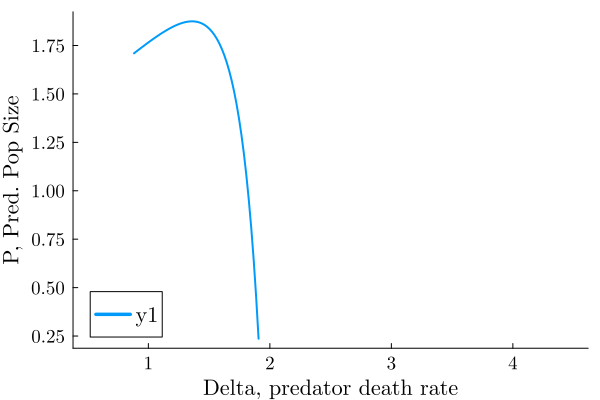

In [10]:
# set at beginning
params = deepcopy(params_base)
x = 2.0
params[:x] = x
params[:A2] = 0.9
params[:H2b] = 3.5
params[:β2] = 1.0
r2 = 6.0

# empty vector to fill
len = 200
Pvec = zeros(len)


@unpack scale = params
δvec = range(0.5, stop=4.5, length=len)
for (i,δ) in enumerate(δvec)

    # get normal scaled parameters dictionary or named tuple
    eta1_over_eta2 = 1/scale
    η2 = 1/ (δ/r2 + 1 + eta1_over_eta2)
    params[:η2] = η2
    params_new = (;params..., η2 = η2)
    params_new_scaled = scale_parameters(params_new)


    u_out = equilibrium_nogroups(params_new_scaled)
    if all(u_out .> 0)
        Pvec[i] = u_out[end]
    else
        Pvec[i] = NaN
    end
end

plot(
    δvec, Pvec, xlabel="Delta, predator death rate", 
    ylabel="P, Pred. Pop Size",
    lw=2)

## Plot Heatmap varying delta and H2b

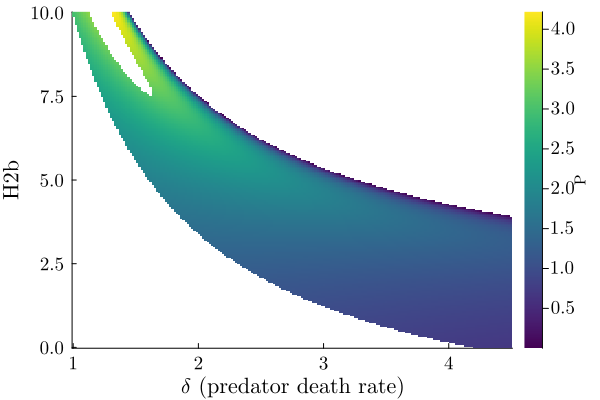

In [11]:
# Base params (same as your 1D sweep)

params0 = deepcopy(params_base)
params0[:x]   = 2.0
params0[:A2]  = 0.9
params0[:β2]  = 2.0
r2 = 6.0
scale = params0[:scale]

# Grids
nδ   = 200
nH   = 200
δvec   = range(1.0, stop=4.5, length=nδ)
H2bvec = range(0.0, stop=10.0, length=nH)  # adjust range as needed

# Output matrix: rows = H2b, cols = δ
Pmat = fill(NaN, nH, nδ)
for (j, δ) in enumerate(δvec)
    η2 = 1 / (δ/r2 + 1 + 1/scale)
    for (i, H2b) in enumerate(H2bvec)
        # build clean param set for this (δ, H2b)
        p = (; params0..., η2 = η2, H2b = H2b)
        p_scaled = scale_parameters(p)
        u_eq = equilibrium_nogroups(p_scaled)  # returns [N1, N2, P]
        J = ForwardDiff.jacobian(u -> system_nogroups(u, p_scaled, 1),u_eq)
        evals_real = real(eigen(J).values)
        
        if all(u_eq .> 0) && all(evals_real .< 0)
            Pmat[i, j] = u_eq[end]
        end
    end
end

heatmap(
    δvec, H2bvec, Pmat;
    xlabel = L"$\delta$ (predator death rate)",
    ylabel = "H2b",
    colorbar_title = "P",
    c = :viridis,
    nan_color = :white,
    lw = 0,
)